In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os

In [2]:
# Donot use these cells
# Erythroblast (ERB)
# Immature Granulocytes (IG)
# Platelet (PLATELET)
# Band Neutrophils (BNE)
# Segmented Neutrophils (SNE)

In [3]:
! gdown https://drive.google.com/u/0/uc?id=1gSe7K_D3MKUsUCU2uRbTcXTmlSRVaAqh

Downloading...
From: https://drive.google.com/u/0/uc?id=1gSe7K_D3MKUsUCU2uRbTcXTmlSRVaAqh
To: /content/PBC_dataset_normal_DIB_cropped.zip
263MB [00:04, 64.6MB/s]


In [4]:
! unzip -qq PBC_dataset_normal_DIB_cropped.zip

In [5]:
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *ERB*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *IG*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *PLATELET*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *BNE*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *SNE*)

In [6]:
# ! rm -rf /content/PBC_dataset_normal_DIB_cropped/erythroblast
# ! rm -rf erythroblast
# ! rm -rf erythroblast

# ! rm -rf erythroblast


In [7]:
name_dict = {
        "BA": 1,
        "EO": 2,
        "MMY": 3,
        "MY": 3,
        "PMY": 3,
        "LY": 4,
        "MO": 5,
        "NEUTROPHIL": 6,
        
}


class_names = [
      "basophil","eosinophil",  "ig", "lymphocyte", "monocyte", "neutrophil"
]

In [8]:
freq_count = {}
for class_name in class_names:
  files = glob.glob("PBC_dataset_normal_DIB_cropped/" + class_name + "/*")
  for file in files:
    name = os.path.basename(file).split("_")[0]
    freq_count[name] = freq_count.get(name, 0) + 1

In [9]:
freq_count

{'BA': 1218,
 'EO': 3117,
 'LY': 1214,
 'MMY': 1015,
 'MO': 1420,
 'MY': 1137,
 'NEUTROPHIL': 50,
 'PMY': 592}

In [10]:
def parse_filepath(filepath):
    try:
        #path, filename = os.path.split(filepath)
        label = os.path.basename(filepath).split("_")[0]
        #filename, ext = os.path.splitext(filename)
        #label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [11]:
DATA_DIR = 'PBC_dataset_normal_DIB_cropped'
H, W, C = 360, 360, 3

In [12]:
files = glob.glob("{}/*/*.jpg".format(DATA_DIR))
print("Total files = ",len(files))

Total files =  9763


In [13]:
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

label                                              file
0   PMY  PBC_dataset_normal_DIB_cropped/ig/PMY_938401.jpg
1    MY   PBC_dataset_normal_DIB_cropped/ig/MY_188945.jpg
2   PMY  PBC_dataset_normal_DIB_cropped/ig/PMY_910991.jpg
3    MY   PBC_dataset_normal_DIB_cropped/ig/MY_242857.jpg
4    MY   PBC_dataset_normal_DIB_cropped/ig/MY_513277.jpg

In [14]:
# Fixing random state for reproducibility
np.random.seed(19680801)

train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])

In [15]:
print(len(train))
print(len(validate))
print(len(test))

7810
976
977


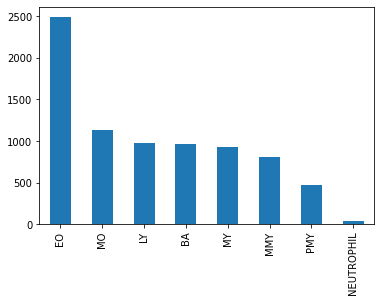

In [16]:
train['label'].value_counts().plot.bar()
plt.savefig("train_dist.jpg", bbox_inches='tight', pad_inches=0.1)
plt.savefig("train_dist.eps", bbox_inches='tight', pad_inches=0.1)

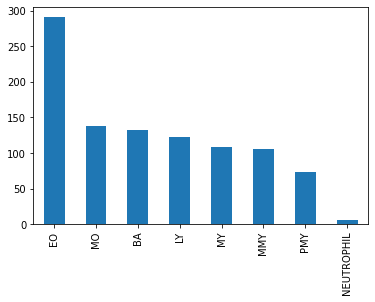

In [17]:
validate['label'].value_counts().plot.bar()

In [18]:
train.head()

label                                               file
8372    EO  PBC_dataset_normal_DIB_cropped/eosinophil/EO_5...
8756    LY  PBC_dataset_normal_DIB_cropped/lymphocyte/LY_5...
360    PMY   PBC_dataset_normal_DIB_cropped/ig/PMY_287140.jpg
96     PMY   PBC_dataset_normal_DIB_cropped/ig/PMY_713436.jpg
1783    MY    PBC_dataset_normal_DIB_cropped/ig/MY_612971.jpg

In [19]:
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=360,
                            zoom_range=[0.9,1.0],
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.20,
                            horizontal_flip=True,
                            vertical_flip=True,
                            brightness_range=[0.8,1.0],
                            fill_mode="nearest")

In [20]:
batch_size=24

In [21]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/",
    x_col="file",
    y_col="label",
    seed=42,
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    #save_to_dir="./train/",
    target_size=(H, W)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate,
    directory="/content/",
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    #save_to_dir="./validation/",
    target_size=(H,W)
)

Found 7810 validated image filenames belonging to 8 classes.
Found 976 validated image filenames belonging to 8 classes.


In [22]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

class_weights = {i : class_weights[i] for i in range(len(name_dict))}

print("Weights: ")

for cl, id in train_generator.class_indices.items():
  print(cl, class_weights[id])

Weights: 
BA 1.0095656670113753
EO 0.39191087916499395
LY 0.9971910112359551
MMY 1.209727385377943
MO 0.8624116607773852
MY 1.0554054054054054
NEUTROPHIL 23.8109756097561
PMY 2.0860042735042734


In [23]:
N_LABELS = len(name_dict)
D = 1

In [24]:
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, \
                                    GlobalMaxPool2D, Dropout, SpatialDropout2D, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model

# m1_1, m1_2, l1_1, l1_2, m2_1, m2_2, l2_1, l2_2, m3_1, m3_2, m3_1, m3_2, l3_1, l3_2, m4_1, 

def Classification(H,W,C):
    
    input_layer = tf.keras.Input(shape=(H, W, C))

    m1_1 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_1", padding='same')(input_layer))
    m1_2 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_2", padding='same')(m1_1))
    m1_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_3", padding='same')(m1_2)))

    l1_1 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_1", padding='same')(m1_3))
    l1_2 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_2", padding='same')(l1_1))
    l1_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_3", padding='same')(l1_2)))

    m2_1 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_1", padding='same')(l1_3))
    m2_2 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_2", padding='same')(m2_1))
    m2_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_3", padding='same')(m2_2)))

    l2_1 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_1", padding='same')(m2_3))
    l2_2 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_2", padding='same')(l2_1))
    l2_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_3", padding='same')(l2_2)))


    m3_1 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_1", padding='same')(l2_1))
    m3_2 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_2", padding='same')(m3_1))
    m3_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_3", padding='same')(m3_2)))

    l3_1 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_1", padding='same')(m3_3))
    l3_2 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_2", padding='same')(l3_1))
    l3_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_3", padding='same')(l3_2)))

    m4_1 = BatchNormalization(axis=-1)(Conv2D(256, 3, activation='relu', strides=(2, 2), name="m4_1")(l3_3))
    m4_2 = BatchNormalization(axis=-1)(Conv2D(256, 3, activation='relu', strides=(2, 2), name="m4_2")(m4_1))
    # m4_3 = BatchNormalization(axis=-1)(Conv2D(512, 3, activation='relu', strides=(2, 2), name="m4_3")(m4_2))
    # m4_4 = BatchNormalization(axis=-1)(Conv2D(512, 3, activation='relu', strides=(2, 2), name="m4_4")(m4_3))


    #x = SpatialDropout2D(0.5, name="dropout_3")(m4_4)
    x = Flatten(name="flatten")(m4_2)
    x = Dense(512, activation='relu', name="dense_512")(x)
    x = Dense(N_LABELS, activation='softmax', name="output_layer")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    return model


model = Classification(H,W,C)

opt = Adam(learning_rate=1e-5)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
m1_1 (Conv2D)                (None, 360, 360, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 360, 360, 32)      128       
_________________________________________________________________
m1_2 (Conv2D)                (None, 360, 360, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 360, 360, 32)      128       
_________________________________________________________________
m1_3 (Conv2D)                (None, 360, 360, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 360, 360, 32)      128   

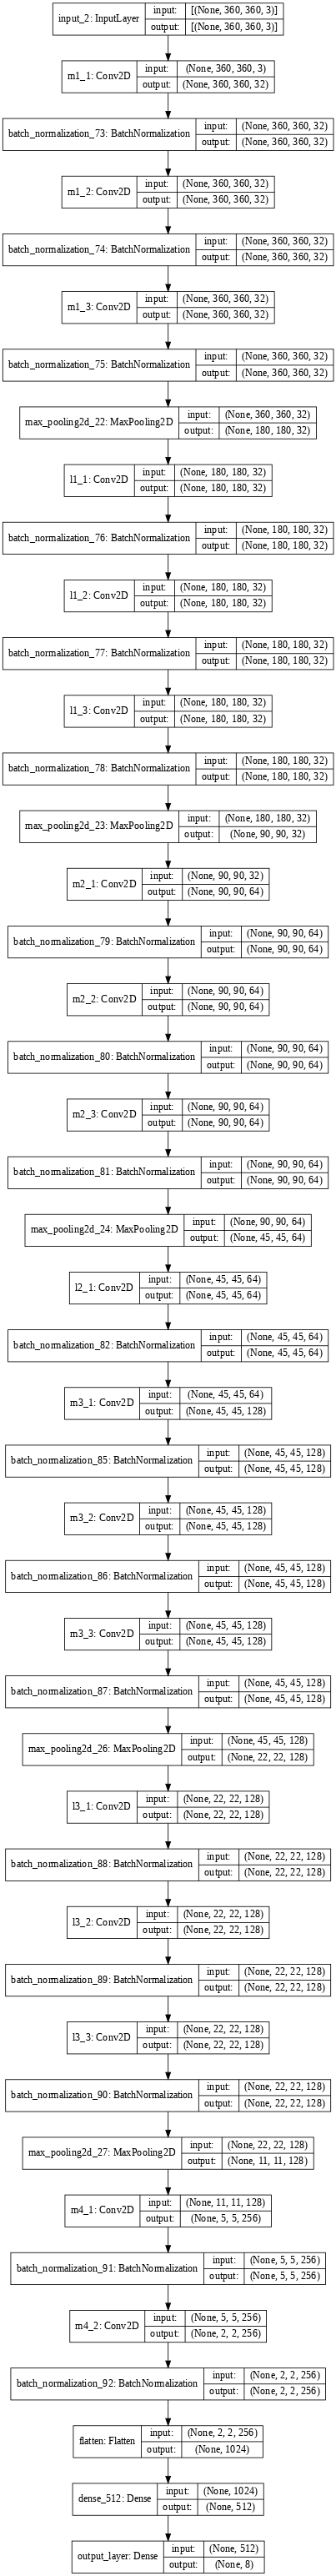

In [ ]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)
]
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [26]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback,callbacks],
)

# loss: 1.5260 - accuracy: 0.4220 - val_loss: 1.4034 - val_accuracy: 0.5354

Epoch 1/10
325/325 [==============================] - 344s 946ms/step - loss: 2.5997 - accuracy: 0.2602 - val_loss: 1.7384 - val_accuracy: 0.3719
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/10
325/325 [==============================] - 306s 943ms/step - loss: 1.7851 - accuracy: 0.4023 - val_loss: 1.4119 - val_accuracy: 0.4802
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/10
325/325 [==============================] - 305s 939ms/step - loss: 1.5177 - accuracy: 0.4652 - val_loss: 1.2836 - val_accuracy: 0.5146
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 4/10
325/325 [==============================] - 306s 941ms/step - loss: 1.4125 - accuracy: 0.5017 - val_loss: 1.1973 - val_accuracy: 0.5302
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 5/10
325/325 [==============================] - 304s 934ms/step - loss: 1.2992 - accuracy: 0.5217 - val_loss: 1.1177 - val_accuracy: 0.5635
INFO:tensorflow:Assets wri

In [27]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history_classification_model_10e.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

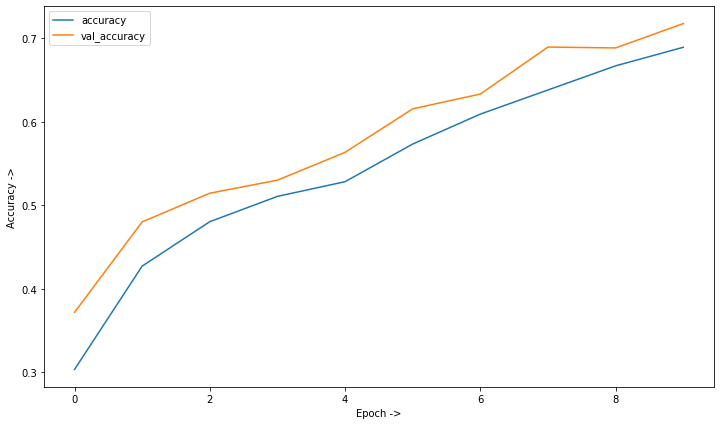

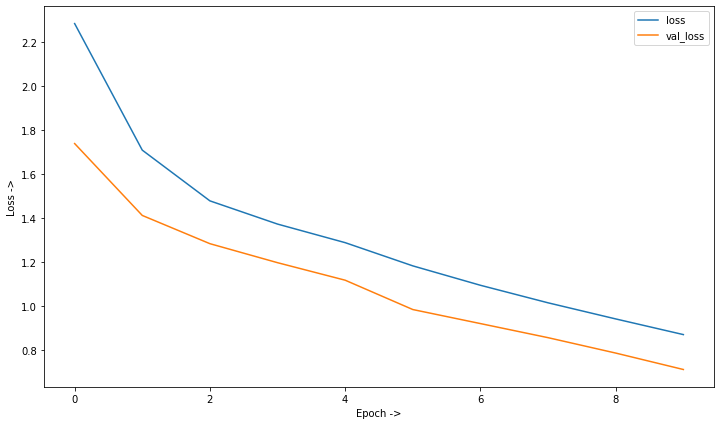

In [28]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['accuracy']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [29]:
model.save('classification_model_blood.h5')

In [30]:
from tensorflow import keras
model = keras.models.load_model('classification_model_blood.h5')

In [38]:
test_datagen=ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

test_generator=test_datagen.flow_from_dataframe(
    #rescale=1./255.,
    dataframe=test,
    directory="/content/",
    x_col="file",
    y_col=None,
    batch_size=10,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(W,H)
)

Found 977 validated image filenames.


In [39]:
import math
STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)

In [40]:
test_generator.reset()
pred = model.predict_generator(test_generator,
  steps=STEP_SIZE_TEST,
  verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


98/98 [==============================] - 27s 272ms/step


In [41]:
predicted_class_indices=np.argmax(pred,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(len(predictions))

977


In [42]:
filenames=test_generator.filenames
print(len(filenames))
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

977


In [43]:
file = results.iloc[5]["Filename"]
test[test.file == file]["label"]

7970    EO
Name: label, dtype: object

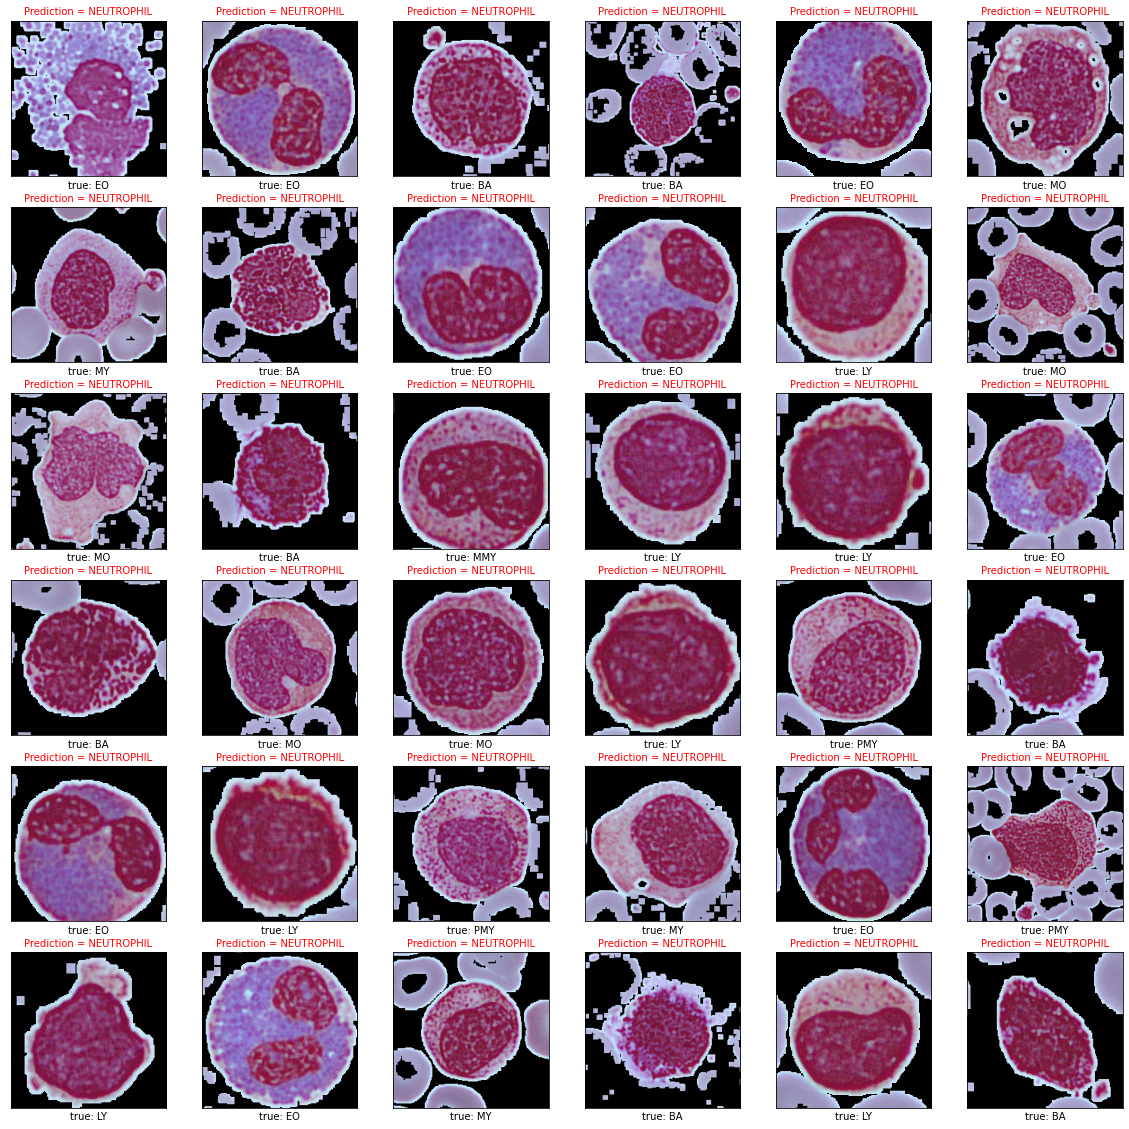

In [44]:
import math
n = 36
random_indices = np.random.permutation(n)
n_cols = 6
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    filename = results.iloc[img_idx]["Filename"]
    ax.imshow(cv2.imread(filename))
    actual_pred = results.iloc[img_idx]["Predictions"]
    true_val = parse_filepath(filename)
    if actual_pred == true_val:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('green')
    else:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('red')
    ax.set_xlabel('true: {}'.format(true_val),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

In [46]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

%matplotlib inline

In [47]:
# Taking the outputs of first 100 layers from trained model, leaving the first Input layer, in a list
layer_outputs = [layer.output for layer in model.layers[1:100]]

# This is image of a Rose flower from our dataset. All of the visualizations in this cell are of this image.
test_image = files[0]

# Loading the image and converting it to a numpy array for feeding it to the model. Its important to use expand_dims since our original model takes batches of images
# as input, and here we are feeding a single image to it, so the number of dimensions should match for model input.
img = image.load_img(test_image, target_size=(360, 360))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.

# Defining a new model using original model's input and all the 100 layers outputs and then predicting the values for all those 100 layers for our test image.
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# These are names of layers, the outputs of which we are going to visualize.
layer_names = ['m1_1', 'm1_2', 'l1_1', 'l1_2', 'm2_1', 'm2_2', 'l2_1', 'l2_2', 'm3_1', 'm3_2', 'm3_1', 'm3_2', 'l3_1', 'l3_2', 'm4_1', 'm4_2']
print(len(activations))
activ_list = [activations[0], activations[5], activations[10], activations[15], activations[20], activations[25], activations[30], activations[35], activations[40]]

44


In [ ]:
#https://www.kaggle.com/anktplwl91/visualizing-what-your-convnet-learns

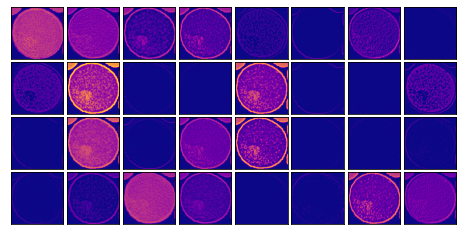

In [48]:
# Visualization of the activation maps from first convolution layer. Different filters activate different parts of the image, like some are detecting edges, some are
# detecting background, while others are detecting just the outer boundary of the flower and so on.
fig = plt.figure(figsize=(8, 4))
for img in range(32):
    ax = fig.add_subplot(4, 8, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)


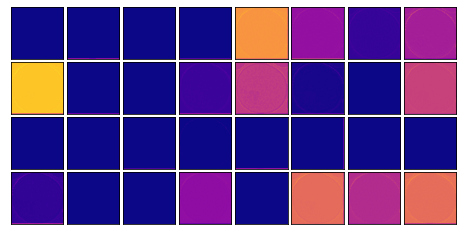

In [49]:
# This is the visualization of activation maps from third convolution layer. In this layer the abstraction has increased. Filters are now able to regognise the edges
# of the flower more closely. Some filters are activating the surface texture of the image as well
fig = plt.figure(figsize=(8, 4))
for img in range(32):
    ax = fig.add_subplot(4, 8, img+1)
    ax = plt.imshow(activations[6][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

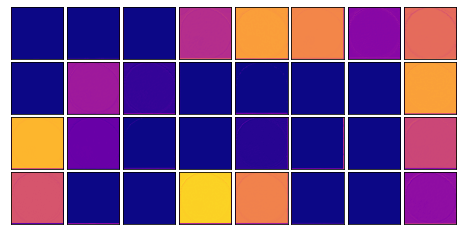

In [50]:
# These are activation maps from fourth convolution layer. The images have become a little blurry, because of the MaxPooling operation done just before this layer. As
# more Pooling layers are introduced the knowledge reaching the convolution layer becomes more and more abstract, which helps the complete network to finally classify
# the image properly, but visually they don't provide us with much information.
fig = plt.figure(figsize=(8, 4))
for img in range(32):
    ax = fig.add_subplot(4, 8, img+1)
    ax = plt.imshow(activations[10][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)



In [51]:
activations[17].shape

(1, 90, 90, 64)

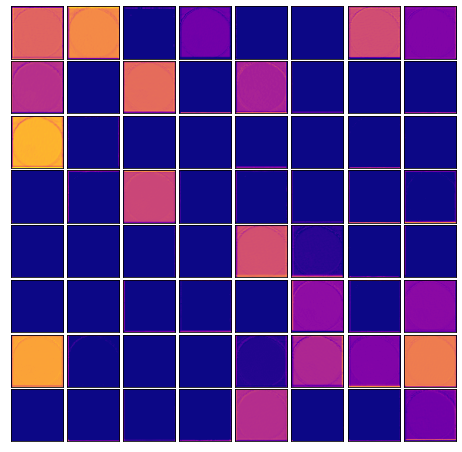

In [52]:
# These are the activation maps from next convolution layer after next MaPooling layer. The images have become more blurry
fig = plt.figure(figsize=(8, 8))
for img in range(64):
    ax = fig.add_subplot(8, 8, img+1)
    ax = plt.imshow(activations[17][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)


In [53]:
activations[39].shape

(1, 2, 2, 256)

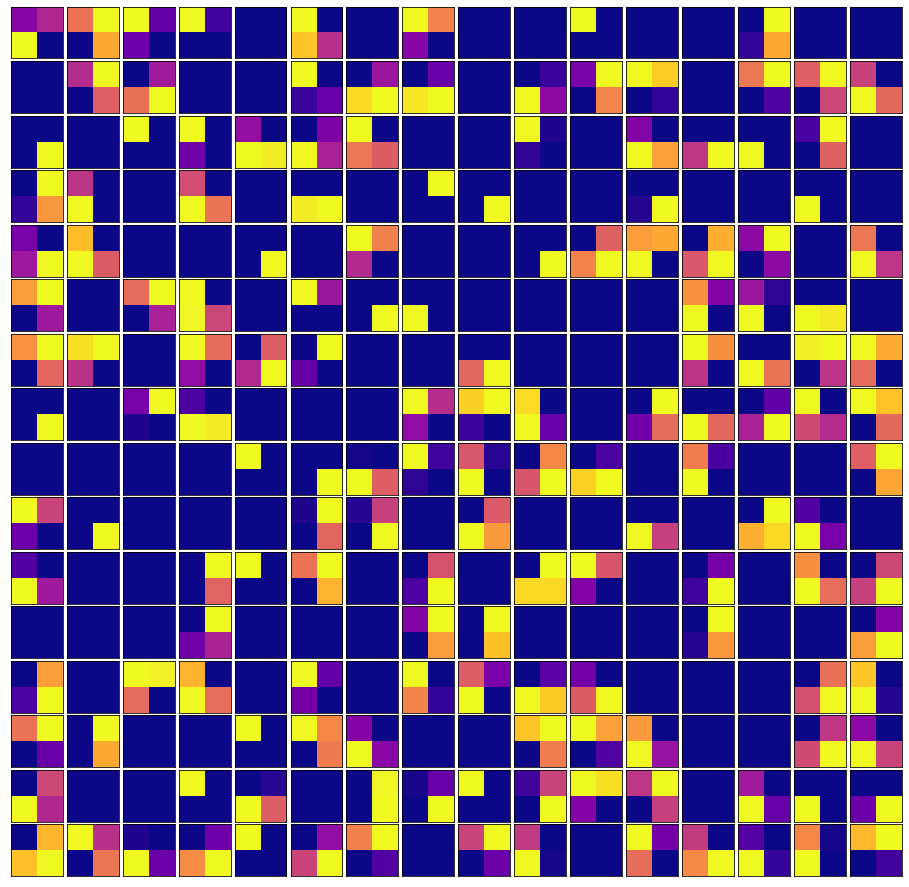

In [54]:
# Activation maps from first Concatenate layer Mixed0, which concatenates the ReLU activated outputs from four convolution layers.
fig = plt.figure(figsize=(16, 16))
for img in range(256):
    ax = fig.add_subplot(16, 16, img+1)
    ax = plt.imshow(activations[39][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)


In [ ]:
# The purpose of this function is to just convert a numpy array to a standard image format, so that it can be displayed and viewed comfortably
def deprocess_image(x):
    
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')

    return x

In [ ]:
# This function is used to create a loss function that maximizes the value of a given filter in a convolution layer, and then we use SGD to adjust the values of the
# input image so as to maximize this activation value. We pass the layer name and the filter index to the function as arguments. 'loss' is the mean for that particular
# filter, 'grads' is the gradient calculated for this loss with respect to input image. Finally, SGD is run for 80 iterations which continuously maximizes the response
# to input image by adding the gradient. Finally, it uses 'deprocess_image' to convert this array to a representable image format.

def generate_pattern(layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(80):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)


TypeError: ignored

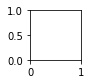

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Below are the patterns to which the filters from first convolution layer get activated. As we can see these are very basic cross-sectional patterns formed by
# horizontal and vertical lines, which is what the these filters look in the input image and get activated if they find one.
fig = plt.figure(figsize=(2, 2))
for img in range(4):
    ax = fig.add_subplot(2, 2, img+1)
    ax = plt.imshow(generate_pattern('conv2d_15', img))
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)


In [ ]:
# 'm1_1', 'm1_2', 'l1_1', 'l1_2', 'm2_1', 'm2_2', 'l2_1', 'l2_2', 'm3_1', 'm3_2', 'm3_1', 'm3_2', 'l3_1', 'l3_2', 'm4_1', 'm4_2'

import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 360
img_height = 360
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "m2_2"


In [ ]:
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [ ]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [ ]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)


AssertionError: ignored

In [ ]:
! pip install keras-vis

In [ ]:
from keras.applications import VGG16

from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.input_modifiers import Jitter
from vis.optimizer import Optimizer
from vis.callbacks import GifGenerator

import tensorflow.compat.v2.feature_column as fc

# Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)
print('Model loaded.')

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'm2_2'
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
output_class = [1]

losses = [
    (ActivationMaximization(layer_dict[layer_name], output_class), 2),
    (LPNorm(model.input), 10),
    (TotalVariation(model.input), 10)
]
opt = Optimizer(model.input, losses)
opt.minimize(max_iter=500, verbose=True, input_modifiers=[Jitter()], callbacks=[GifGenerator('opt_progress')])

Model loaded.


TypeError: ignored